# Barabasi-Albert model

In [99]:
import networkx as nx
import numpy as np
import random as rd
import matplotlib.pyplot as plt

## Parameters

The algorithm has 3 input parameters: 
* m_0: number of initial nodes
* N: number of final nodes
* m: number of links for each new added node (should be m < m_0)

Insert the parameters of the algorithm (need to add the checks!!!!!!!!!)

In [100]:
# Insert Parameters
m_0 = int(input("Insert he number of initial nodes:\n"))
N = int(input("\nInsert number of final nodes:\n"))
m = int(input("\nInsert in the value of m parameter:\n"))
if m < 1 or  m >=n:
        raise nx.NetworkXError("Barabási–Albert network must have m >= 1"
                               " and m < n, m = %d, n = %d" % (m, n))

Insert he number of initial nodes:
10

Insert number of final nodes:
2000

Insert in the value of m parameter:
4


Let's now create the initial graph: we build a complete graph with m_0 nodes

In [101]:
G = nx.complete_graph(m_0) # nodes in the range from 0 to m_0

In [4]:
len(G.nodes())

10

In [5]:
# list the nodes
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9))

We now need to add incrementally nodes until N (we'll add nodes by increasing the number identifying each node). 
We use a loop to do that. After adding a node we need to add m links from it to the existing nodes, we'll use another (nested) loop to do that.

## Auxiliary functions
Before implementing the actual code of the algorithm, lets define some helper functions for creating m links between the newly added node and the existing nodes according to the prefential attachment mechanism

The first function we'll define builds the weighted probabilities of the graph nodes.

In [102]:
# returns the list of the weighted probability of each existing node
def build_probs(G):
    nodes_probs = [] # our list
                            
    # compute the probability for each node
    for node in G.nodes():
        node_deg = G.degree(node)
        
        # probability of the node
        node_prob = node_deg / (2 * len(G.edges)) # N.B.: 2 * len(G.edges) returns the sum of the degrees of all the nodes, since each edge contributes to the degree of 2 nodes
        
        # insert into the list
        nodes_probs.append(node_prob)
    
    return nodes_probs

The 2nd auxiliary function adds m links between a node and the existing nodes, according to the preferential attachment.
We use the random.choice() function of the numpy module, which takes as input the list of nodes among which to select one and the probability associated to each node.

In [103]:
def add_links(G, added_node):
    selected_nodes = [] # list of the selected nodes
    
    # before inserting the links we build the weighted probabilities of each node
    nodes_probs = build_probs(G)
    
    # add m links
    for added_links in range(m):
        # we use the choice function of the numpy.random module
        selected_node = np.random.choice(G.nodes(),p=nodes_probs) # selects a node according to preferential attachment
        
        # check whether the node was already selected (to avoid multiple links)
        while selected_node in selected_nodes:
            selected_node = np.random.choice(G.nodes(),p=nodes_probs) # select another node
        
        # once we selected the node we should create the link among the added_node given as a parameter
        # and the selected_node
        G.add_edge(added_node, selected_node)
        

## Algorithm

In [104]:
nodes_to_add = N - m_0 # number of nodes to add until reaching N total nodes
inserted_nodes = 0 # counter of the inserted nodes

for n_i in range(nodes_to_add):
     
    # insert new_node in the graph
    print("--------------- STEP: {} ---------------".format(inserted_nodes + 1))
    G.add_node(m_0 + inserted_nodes) # we add the node by specifying its numeric value (starting from 50)
    added_node = m_0 + inserted_nodes # identifier of the added node
    inserted_nodes += 1
    
    print("Node added: {}".format(added_node))
    # add the newly inserted node into nodes_probs because of the random.choice function to work
    
    # --------------------------------------------------------------

    # after adding the node, we need to create m links with the existing nodes 
    # according to the preferential attachment mechanism
    
    # function to add m links to the newly inserted node
    add_links(G, added_node)

--------------- STEP: 1 ---------------
Node added: 10
--------------- STEP: 2 ---------------
Node added: 11
--------------- STEP: 3 ---------------
Node added: 12
--------------- STEP: 4 ---------------
Node added: 13
--------------- STEP: 5 ---------------
Node added: 14
--------------- STEP: 6 ---------------
Node added: 15
--------------- STEP: 7 ---------------
Node added: 16
--------------- STEP: 8 ---------------
Node added: 17
--------------- STEP: 9 ---------------
Node added: 18
--------------- STEP: 10 ---------------
Node added: 19
--------------- STEP: 11 ---------------
Node added: 20
--------------- STEP: 12 ---------------
Node added: 21
--------------- STEP: 13 ---------------
Node added: 22
--------------- STEP: 14 ---------------
Node added: 23
--------------- STEP: 15 ---------------
Node added: 24
--------------- STEP: 16 ---------------
Node added: 25
--------------- STEP: 17 ---------------
Node added: 26
--------------- STEP: 18 ---------------
Node added: 27
-

--------------- STEP: 148 ---------------
Node added: 157
--------------- STEP: 149 ---------------
Node added: 158
--------------- STEP: 150 ---------------
Node added: 159
--------------- STEP: 151 ---------------
Node added: 160
--------------- STEP: 152 ---------------
Node added: 161
--------------- STEP: 153 ---------------
Node added: 162
--------------- STEP: 154 ---------------
Node added: 163
--------------- STEP: 155 ---------------
Node added: 164
--------------- STEP: 156 ---------------
Node added: 165
--------------- STEP: 157 ---------------
Node added: 166
--------------- STEP: 158 ---------------
Node added: 167
--------------- STEP: 159 ---------------
Node added: 168
--------------- STEP: 160 ---------------
Node added: 169
--------------- STEP: 161 ---------------
Node added: 170
--------------- STEP: 162 ---------------
Node added: 171
--------------- STEP: 163 ---------------
Node added: 172
--------------- STEP: 164 ---------------
Node added: 173
--------------

--------------- STEP: 294 ---------------
Node added: 303
--------------- STEP: 295 ---------------
Node added: 304
--------------- STEP: 296 ---------------
Node added: 305
--------------- STEP: 297 ---------------
Node added: 306
--------------- STEP: 298 ---------------
Node added: 307
--------------- STEP: 299 ---------------
Node added: 308
--------------- STEP: 300 ---------------
Node added: 309
--------------- STEP: 301 ---------------
Node added: 310
--------------- STEP: 302 ---------------
Node added: 311
--------------- STEP: 303 ---------------
Node added: 312
--------------- STEP: 304 ---------------
Node added: 313
--------------- STEP: 305 ---------------
Node added: 314
--------------- STEP: 306 ---------------
Node added: 315
--------------- STEP: 307 ---------------
Node added: 316
--------------- STEP: 308 ---------------
Node added: 317
--------------- STEP: 309 ---------------
Node added: 318
--------------- STEP: 310 ---------------
Node added: 319
--------------

--------------- STEP: 437 ---------------
Node added: 446
--------------- STEP: 438 ---------------
Node added: 447
--------------- STEP: 439 ---------------
Node added: 448
--------------- STEP: 440 ---------------
Node added: 449
--------------- STEP: 441 ---------------
Node added: 450
--------------- STEP: 442 ---------------
Node added: 451
--------------- STEP: 443 ---------------
Node added: 452
--------------- STEP: 444 ---------------
Node added: 453
--------------- STEP: 445 ---------------
Node added: 454
--------------- STEP: 446 ---------------
Node added: 455
--------------- STEP: 447 ---------------
Node added: 456
--------------- STEP: 448 ---------------
Node added: 457
--------------- STEP: 449 ---------------
Node added: 458
--------------- STEP: 450 ---------------
Node added: 459
--------------- STEP: 451 ---------------
Node added: 460
--------------- STEP: 452 ---------------
Node added: 461
--------------- STEP: 453 ---------------
Node added: 462
--------------

--------------- STEP: 580 ---------------
Node added: 589
--------------- STEP: 581 ---------------
Node added: 590
--------------- STEP: 582 ---------------
Node added: 591
--------------- STEP: 583 ---------------
Node added: 592
--------------- STEP: 584 ---------------
Node added: 593
--------------- STEP: 585 ---------------
Node added: 594
--------------- STEP: 586 ---------------
Node added: 595
--------------- STEP: 587 ---------------
Node added: 596
--------------- STEP: 588 ---------------
Node added: 597
--------------- STEP: 589 ---------------
Node added: 598
--------------- STEP: 590 ---------------
Node added: 599
--------------- STEP: 591 ---------------
Node added: 600
--------------- STEP: 592 ---------------
Node added: 601
--------------- STEP: 593 ---------------
Node added: 602
--------------- STEP: 594 ---------------
Node added: 603
--------------- STEP: 595 ---------------
Node added: 604
--------------- STEP: 596 ---------------
Node added: 605
--------------

--------------- STEP: 722 ---------------
Node added: 731
--------------- STEP: 723 ---------------
Node added: 732
--------------- STEP: 724 ---------------
Node added: 733
--------------- STEP: 725 ---------------
Node added: 734
--------------- STEP: 726 ---------------
Node added: 735
--------------- STEP: 727 ---------------
Node added: 736
--------------- STEP: 728 ---------------
Node added: 737
--------------- STEP: 729 ---------------
Node added: 738
--------------- STEP: 730 ---------------
Node added: 739
--------------- STEP: 731 ---------------
Node added: 740
--------------- STEP: 732 ---------------
Node added: 741
--------------- STEP: 733 ---------------
Node added: 742
--------------- STEP: 734 ---------------
Node added: 743
--------------- STEP: 735 ---------------
Node added: 744
--------------- STEP: 736 ---------------
Node added: 745
--------------- STEP: 737 ---------------
Node added: 746
--------------- STEP: 738 ---------------
Node added: 747
--------------

--------------- STEP: 864 ---------------
Node added: 873
--------------- STEP: 865 ---------------
Node added: 874
--------------- STEP: 866 ---------------
Node added: 875
--------------- STEP: 867 ---------------
Node added: 876
--------------- STEP: 868 ---------------
Node added: 877
--------------- STEP: 869 ---------------
Node added: 878
--------------- STEP: 870 ---------------
Node added: 879
--------------- STEP: 871 ---------------
Node added: 880
--------------- STEP: 872 ---------------
Node added: 881
--------------- STEP: 873 ---------------
Node added: 882
--------------- STEP: 874 ---------------
Node added: 883
--------------- STEP: 875 ---------------
Node added: 884
--------------- STEP: 876 ---------------
Node added: 885
--------------- STEP: 877 ---------------
Node added: 886
--------------- STEP: 878 ---------------
Node added: 887
--------------- STEP: 879 ---------------
Node added: 888
--------------- STEP: 880 ---------------
Node added: 889
--------------

--------------- STEP: 1005 ---------------
Node added: 1014
--------------- STEP: 1006 ---------------
Node added: 1015
--------------- STEP: 1007 ---------------
Node added: 1016
--------------- STEP: 1008 ---------------
Node added: 1017
--------------- STEP: 1009 ---------------
Node added: 1018
--------------- STEP: 1010 ---------------
Node added: 1019
--------------- STEP: 1011 ---------------
Node added: 1020
--------------- STEP: 1012 ---------------
Node added: 1021
--------------- STEP: 1013 ---------------
Node added: 1022
--------------- STEP: 1014 ---------------
Node added: 1023
--------------- STEP: 1015 ---------------
Node added: 1024
--------------- STEP: 1016 ---------------
Node added: 1025
--------------- STEP: 1017 ---------------
Node added: 1026
--------------- STEP: 1018 ---------------
Node added: 1027
--------------- STEP: 1019 ---------------
Node added: 1028
--------------- STEP: 1020 ---------------
Node added: 1029
--------------- STEP: 1021 -------------

--------------- STEP: 1142 ---------------
Node added: 1151
--------------- STEP: 1143 ---------------
Node added: 1152
--------------- STEP: 1144 ---------------
Node added: 1153
--------------- STEP: 1145 ---------------
Node added: 1154
--------------- STEP: 1146 ---------------
Node added: 1155
--------------- STEP: 1147 ---------------
Node added: 1156
--------------- STEP: 1148 ---------------
Node added: 1157
--------------- STEP: 1149 ---------------
Node added: 1158
--------------- STEP: 1150 ---------------
Node added: 1159
--------------- STEP: 1151 ---------------
Node added: 1160
--------------- STEP: 1152 ---------------
Node added: 1161
--------------- STEP: 1153 ---------------
Node added: 1162
--------------- STEP: 1154 ---------------
Node added: 1163
--------------- STEP: 1155 ---------------
Node added: 1164
--------------- STEP: 1156 ---------------
Node added: 1165
--------------- STEP: 1157 ---------------
Node added: 1166
--------------- STEP: 1158 -------------

--------------- STEP: 1279 ---------------
Node added: 1288
--------------- STEP: 1280 ---------------
Node added: 1289
--------------- STEP: 1281 ---------------
Node added: 1290
--------------- STEP: 1282 ---------------
Node added: 1291
--------------- STEP: 1283 ---------------
Node added: 1292
--------------- STEP: 1284 ---------------
Node added: 1293
--------------- STEP: 1285 ---------------
Node added: 1294
--------------- STEP: 1286 ---------------
Node added: 1295
--------------- STEP: 1287 ---------------
Node added: 1296
--------------- STEP: 1288 ---------------
Node added: 1297
--------------- STEP: 1289 ---------------
Node added: 1298
--------------- STEP: 1290 ---------------
Node added: 1299
--------------- STEP: 1291 ---------------
Node added: 1300
--------------- STEP: 1292 ---------------
Node added: 1301
--------------- STEP: 1293 ---------------
Node added: 1302
--------------- STEP: 1294 ---------------
Node added: 1303
--------------- STEP: 1295 -------------

--------------- STEP: 1416 ---------------
Node added: 1425
--------------- STEP: 1417 ---------------
Node added: 1426
--------------- STEP: 1418 ---------------
Node added: 1427
--------------- STEP: 1419 ---------------
Node added: 1428
--------------- STEP: 1420 ---------------
Node added: 1429
--------------- STEP: 1421 ---------------
Node added: 1430
--------------- STEP: 1422 ---------------
Node added: 1431
--------------- STEP: 1423 ---------------
Node added: 1432
--------------- STEP: 1424 ---------------
Node added: 1433
--------------- STEP: 1425 ---------------
Node added: 1434
--------------- STEP: 1426 ---------------
Node added: 1435
--------------- STEP: 1427 ---------------
Node added: 1436
--------------- STEP: 1428 ---------------
Node added: 1437
--------------- STEP: 1429 ---------------
Node added: 1438
--------------- STEP: 1430 ---------------
Node added: 1439
--------------- STEP: 1431 ---------------
Node added: 1440
--------------- STEP: 1432 -------------

--------------- STEP: 1553 ---------------
Node added: 1562
--------------- STEP: 1554 ---------------
Node added: 1563
--------------- STEP: 1555 ---------------
Node added: 1564
--------------- STEP: 1556 ---------------
Node added: 1565
--------------- STEP: 1557 ---------------
Node added: 1566
--------------- STEP: 1558 ---------------
Node added: 1567
--------------- STEP: 1559 ---------------
Node added: 1568
--------------- STEP: 1560 ---------------
Node added: 1569
--------------- STEP: 1561 ---------------
Node added: 1570
--------------- STEP: 1562 ---------------
Node added: 1571
--------------- STEP: 1563 ---------------
Node added: 1572
--------------- STEP: 1564 ---------------
Node added: 1573
--------------- STEP: 1565 ---------------
Node added: 1574
--------------- STEP: 1566 ---------------
Node added: 1575
--------------- STEP: 1567 ---------------
Node added: 1576
--------------- STEP: 1568 ---------------
Node added: 1577
--------------- STEP: 1569 -------------

--------------- STEP: 1690 ---------------
Node added: 1699
--------------- STEP: 1691 ---------------
Node added: 1700
--------------- STEP: 1692 ---------------
Node added: 1701
--------------- STEP: 1693 ---------------
Node added: 1702
--------------- STEP: 1694 ---------------
Node added: 1703
--------------- STEP: 1695 ---------------
Node added: 1704
--------------- STEP: 1696 ---------------
Node added: 1705
--------------- STEP: 1697 ---------------
Node added: 1706
--------------- STEP: 1698 ---------------
Node added: 1707
--------------- STEP: 1699 ---------------
Node added: 1708
--------------- STEP: 1700 ---------------
Node added: 1709
--------------- STEP: 1701 ---------------
Node added: 1710
--------------- STEP: 1702 ---------------
Node added: 1711
--------------- STEP: 1703 ---------------
Node added: 1712
--------------- STEP: 1704 ---------------
Node added: 1713
--------------- STEP: 1705 ---------------
Node added: 1714
--------------- STEP: 1706 -------------

--------------- STEP: 1827 ---------------
Node added: 1836
--------------- STEP: 1828 ---------------
Node added: 1837
--------------- STEP: 1829 ---------------
Node added: 1838
--------------- STEP: 1830 ---------------
Node added: 1839
--------------- STEP: 1831 ---------------
Node added: 1840
--------------- STEP: 1832 ---------------
Node added: 1841
--------------- STEP: 1833 ---------------
Node added: 1842
--------------- STEP: 1834 ---------------
Node added: 1843
--------------- STEP: 1835 ---------------
Node added: 1844
--------------- STEP: 1836 ---------------
Node added: 1845
--------------- STEP: 1837 ---------------
Node added: 1846
--------------- STEP: 1838 ---------------
Node added: 1847
--------------- STEP: 1839 ---------------
Node added: 1848
--------------- STEP: 1840 ---------------
Node added: 1849
--------------- STEP: 1841 ---------------
Node added: 1850
--------------- STEP: 1842 ---------------
Node added: 1851
--------------- STEP: 1843 -------------

--------------- STEP: 1964 ---------------
Node added: 1973
--------------- STEP: 1965 ---------------
Node added: 1974
--------------- STEP: 1966 ---------------
Node added: 1975
--------------- STEP: 1967 ---------------
Node added: 1976
--------------- STEP: 1968 ---------------
Node added: 1977
--------------- STEP: 1969 ---------------
Node added: 1978
--------------- STEP: 1970 ---------------
Node added: 1979
--------------- STEP: 1971 ---------------
Node added: 1980
--------------- STEP: 1972 ---------------
Node added: 1981
--------------- STEP: 1973 ---------------
Node added: 1982
--------------- STEP: 1974 ---------------
Node added: 1983
--------------- STEP: 1975 ---------------
Node added: 1984
--------------- STEP: 1976 ---------------
Node added: 1985
--------------- STEP: 1977 ---------------
Node added: 1986
--------------- STEP: 1978 ---------------
Node added: 1987
--------------- STEP: 1979 ---------------
Node added: 1988
--------------- STEP: 1980 -------------

In [59]:
nx.write_pajek(G, "test.net")
nx.write_gexf(G, "testttt.gexf")
nx.write_pajek(G, "test2.net")


## Network descriptors

In [107]:
print("Number of nodes: {}".format(G.number_of_nodes()))
#G.nodes()

print("Number of edges: {}".format(G.number_of_edges()))
#G.edges()

degrees_values = [val for key,val in G.degree()] # degree for each node
#degrees_values

print("Min degree: {}".format(np.min(degrees_values)))
print("Max degree: {}".format(np.max(degrees_values)))
print("Avg degree: {}".format(round(np.mean(degrees_values), 4)))
G = nx.Graph(G)

print("Clustering: {}".format(round(nx.average_clustering(G), 4)))
print("Assortativity: {}".format(round(nx.degree_assortativity_coefficient(G), 4)))
print("Avg path length: {}".format(round(nx.average_shortest_path_length(G), 4)))
print("Avg path: {}".format(nx.diameter(G)))

Number of nodes: 2000
Number of edges: 7956
Min degree: 3
Max degree: 156
Avg degree: 7.956
Clustering: 0.0254
Assortativity: -0.0377
Avg path length: 3.3813
Avg path: 5


## Plots
Maybe plotting with Gephi, .....

### Plotting the network

In [ ]:
nx.draw(G, alpha = .3, edge_color = '#40a6d1', node_color = '#40a6d1', node_size=50, with_labels = True)

### Plotting the distribution

BA model has a powerlaw (scale-free) degree disribution.
K_distr() function  for visualizing the distribution using linear or log-log scale.

Degree distribution of Barabási–Albert network is k**(-3) and so it gives a straight line in log-log scale.

In [110]:
# Plotting

def k_distrib(graph, scale='lin', colour='#40a6d1', alpha=.8, fit_line=False, expct_lo=1, expct_hi=10, expct_const=1):
    
    plt.close()
    num_nodes = graph.number_of_nodes()
    max_degree = 0
    
    # Calculate the maximum degree to know the range of x-axis
    for n in graph.nodes():
        if graph.degree(n) > max_degree:
            max_degree = graph.degree(n)
    
    # X-axis and y-axis values
    x = []
    y_tmp = []
    
    # Loop over all degrees until the maximum to compute the portion of nodes for that degree
    for i in range(max_degree + 1):
        x.append(i)
        y_tmp.append(0)
        for n in graph.nodes():
            if graph.degree(n) == i:
                y_tmp[i] += 1
        y = [i / num_nodes for i in y_tmp] 
    
    # Check for the lin / log parameter and set axes scale
    if scale == 'log':
        plt.xscale('log')
        plt.yscale('log')
        plt.title('Degree distribution (log-log scale)')
        plt.ylabel('log(P(k))')
        plt.xlabel('log(k)')
        plt.plot(x, y, linewidth = 0, marker = 'o', markersize = 8, color = colour, alpha = alpha)
        
        if fit_line:
            # Add theoretical distribution line k^-3
            # Note that you need to parametrize it manually
            w = [a for a in range(expct_lo,expct_hi)]
            z = []
            for i in w:
                x = (i**-3) * expct_const # set line's length and fit intercept
                z.append(x)

            plt.plot(w, z, 'k-', color='#7f7f7f')
            
    else:
        plt.plot(x, y, linewidth = 0, marker = 'o', markersize = 8, color = colour, alpha = alpha)
        plt.title('Degree distribution (linear scale)')
        plt.ylabel('P(k)')
        plt.xlabel('k')

    plt.show()


* Linear scale example

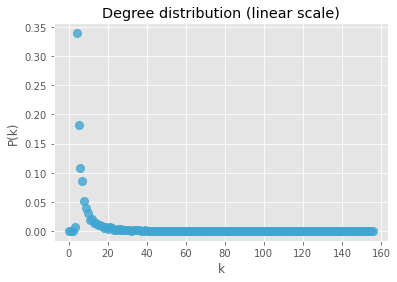

In [111]:
k_distrib(graph=G, colour='#40a6d1', alpha=.8)

* Log-log scale example

C:\Users\denal\AppData\Local\Temp/ipykernel_23072/1533974340.py:45: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(w, z, 'k-', color='#7f7f7f')


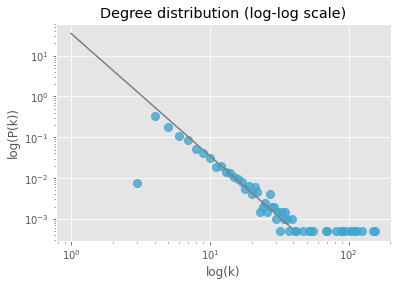

In [112]:
k_distrib(graph=G, colour='#40a6d1', scale='log', alpha=.8, fit_line=True, expct_lo=1, expct_hi=40, expct_const=35)

### Degree distribution plots

In [ ]:
# Auxiliary function to create logaritmically spaced bins (for log-log histogram) by specifying the number of bins
def create_log_bins(degrees, num = 20):
    bins = np.logspace(np.log10(np.min(degrees)), np.log10(np.max(degrees)), num)
    bins = np.array(bins)
    return bins

In [ ]:
# PDF histogram in linear scale
def plot_linear_PDF(G, name='', nbins = 15):
    degrees = [G.degree(n) for n in G.nodes()]
    #plt.figure(figsize=(12,8))
    plt.title('PDF in linear scale', fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('PDF', fontsize=13)
    plt.hist(degrees, bins=nbins, density = True, cumulative = False)
    plt.tight_layout()
    plt.style.use('ggplot')
        
#plot_linear_PDF(G)

In [ ]:
# PDF histogram in Log-Log scale
def plot_loglog_PDF(G, name="", nbins=20):
    degrees = [G.degree(n) for n in G.nodes()]
    
    # creating logaritmically spaced bins
    bins = create_log_bins(degrees, num = nbins)
    
    #plt.figure(figsize=(12,8))
    plt.title('PDF in log-log scale',  fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('PDF', fontsize=13)
    plt.yscale('log')
    plt.xscale('log')
    plt.hist(degrees, bins=bins, density = True, cumulative = False)
    plt.tight_layout()
    #plt.style.use('ggplot')

#plot_loglog_PDF(G)

In [ ]:
# CCDF histogram in linear scale
def plot_linear_CCDF(G, name="", nbins=30):
    degrees = [G.degree(n) for n in G.nodes()]
    #plt.figure(figsize=(12,8))
    plt.title('CCDF in linear scale', fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('CCDF', fontsize=13)
    plt.hist(degrees, bins=nbins, density = True, cumulative = -1)
    plt.tight_layout()
    #plt.style.use('ggplot')

#plot_linear_CCDF(G)

In [ ]:
# CCDF histogram in Log-Log scale
def plot_loglog_CCDF(G, name="", nbins=30):
    degrees = [G.degree(n) for n in G.nodes()]
    
    # creating logaritmically spaced bins
    bins = create_log_bins(degrees, num=nbins)
    
    #plt.figure(figsize=(12,8))
    plt.title('CCDF in log-log scale', fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('CCDF', fontsize=13)
    plt.yscale('log')
    plt.xscale('log')
    plt.hist(degrees, bins=bins, density = True, cumulative = -1)
    plt.tight_layout()
    #plt.style.use('ggplot')
    

#plot_loglog_CCDF(G)

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plot_linear_PDF(G, nbins=20) 
plt.subplot(1, 2, 2)
plot_loglog_PDF(G, nbins=20)
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plot_linear_CCDF(G, nbins=20) 
plt.subplot(1, 2, 2)
plot_loglog_CCDF(G, nbins=20)
plt.show()

## Estimation of the exponent for the empirical degree distributions of BA and CM(SF), for the networks of size N>=1000.

We can use the powerlaw Python package described here: https://arxiv.org/abs/1305.0215, which is based on a MLE

In [ ]:
#pip install powerlaw
#pip install mpmath 

In [114]:
import powerlaw
degrees = [G.degree(n) for n in G.nodes()]
#results = powerlaw.Fit(degrees, discrete = True)
results = powerlaw.Fit(degrees)
#print(round(results.power_law.alpha, 4))
#results.truncated_power_law.parameter1 # power law  parameter (alpha)
results.power_law.alpha
#results.truncated_power_law.parameter2 # exponential cut-off parameter (beta)
#print(results.power_law.xmin)

Calculating best minimal value for power law fit


3.1183869668222575

### Using Linear Regression